<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="cognitiveclass.ai logo">
</center>


# Machine Learning Foundation

## Course 4, Part c: Clustering Methods LAB


# Clustering Methods Exercises


## Introduction

This lab uses a dataset on wine quality. The data set contains various chemical properties of wine, such as acidity, sugar, pH, and alcohol. It also contains a quality metric (3-9, with highest being better) and a color (red or white). The name of the file is `Wine_Quality_Data.csv`.

We will be using the chemical properties (i.e. everything but quality and color) to cluster the wine. Though this is unsupervised learning, there are interesting semi-supervised extensions relating clustering results onto color and quality.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster import hierarchy
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit

In [4]:
import warnings

warnings.filterwarnings('ignore')

## Question 1

*   Import the data and examine the features.
*   Note which are continuous, categorical, and boolean.
*   How many entries are there for the two colors and range of qualities?
*   Make a histogram plot of the quality for each of the wine colors.


In [5]:
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%202/Wine_Quality_Data.csv")
data.head(4)

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   

   alcohol  quality color  
0      9.4        5   red  
1      9.8        5   red  
2      9.8        5   red  
3      9.8        6   red

In [6]:
data.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
color                    object
dtype: object

array([[<Axes: title={'center': 'fixed_acidity'}>,
        <Axes: title={'center': 'volatile_acidity'}>,
        <Axes: title={'center': 'citric_acid'}>],
       [<Axes: title={'center': 'residual_sugar'}>,
        <Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free_sulfur_dioxide'}>],
       [<Axes: title={'center': 'total_sulfur_dioxide'}>,
        <Axes: title={'center': 'density'}>,
        <Axes: title={'center': 'pH'}>],
       [<Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>,
        <Axes: title={'center': 'quality'}>]], dtype=object)

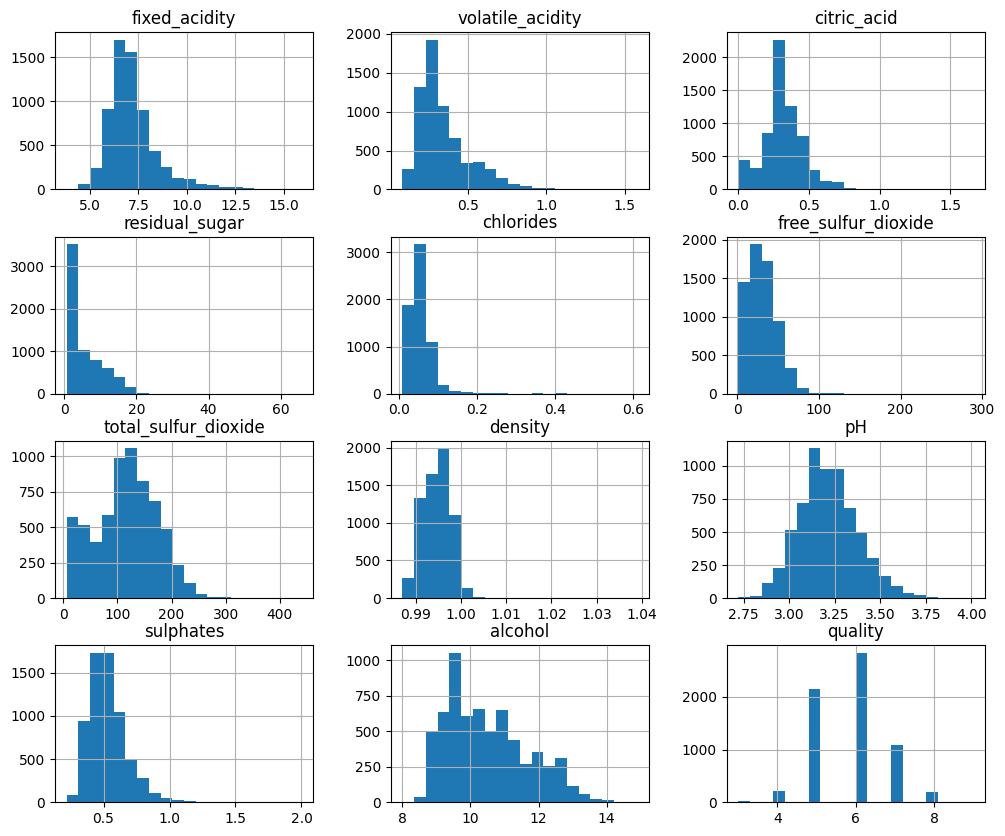

In [7]:
data.hist(bins=20, figsize=(12, 10))

[Text(3.5, 0, '3'),
 Text(4.5, 0, '4'),
 Text(5.5, 0, '5'),
 Text(6.5, 0, '6'),
 Text(7.5, 0, '7'),
 Text(8.5, 0, '8'),
 Text(9.5, 0, '9')]

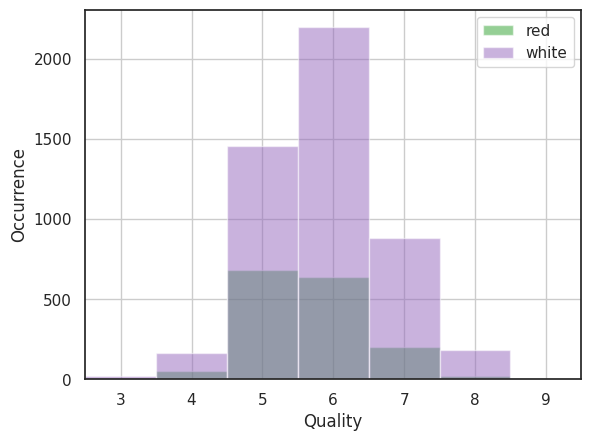

In [8]:
sns.set_context('notebook')
sns.set_style('white')

y_columns = ['red', 'white']
red = sns.color_palette()[2]
white = sns.color_palette()[4]
bin_range = np.array([3, 4, 5, 6, 7, 8, 9])
ax = plt.axes()

for color, plot_color in zip(y_columns, [red, white]):
    sub_data = data.loc[data['color'] == color, 'quality']
    sub_data.hist(bins=bin_range,
                  alpha=0.5,
                  ax=ax,
                  color=plot_color,
                  label=color)

ax.legend()
ax.set(xlabel='Quality', ylabel='Occurrence')

ax.set_xlim(3,10)
ax.set_xticks(bin_range+0.5)
ax.set_xticklabels(bin_range)

## Question 2

*   Examine the correlation and skew of the relevant variables--everything except color and quality (without dropping these columns from our data).
*   Perform any appropriate feature transformations and/or scaling.
*   Examine the pairwise distribution of the variables with pairplots to verify scaling and normalization efforts.


In [9]:
float_columns = [col for col in data.columns if col not in ['color', 'quality']]

In [10]:
corr_mat = data[float_columns].corr()

for x in range(len(float_columns)):
    corr_mat.iloc[x, x] = 0.0

<Axes: >

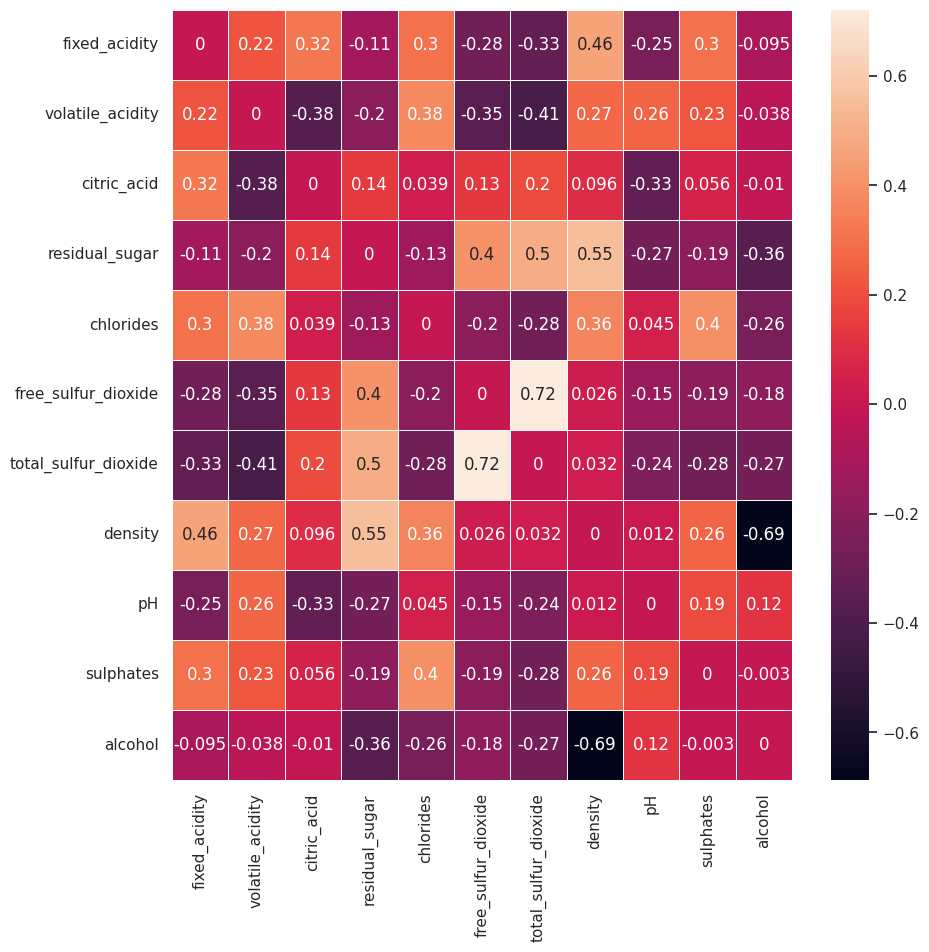

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_mat,
            annot=True,
            linewidths=.5,
            ax=ax)

Examination of skew.

In [12]:
skew_columns = (data[float_columns]
                .skew()
                .sort_values(ascending=False))
skew_columns = skew_columns.loc[skew_columns > 0.75]
skew_columns

chlorides              5.399828
sulphates              1.797270
fixed_acidity          1.723290
volatile_acidity       1.495097
residual_sugar         1.435404
free_sulfur_dioxide    1.220066
dtype: float64

In [13]:
skewed_column_names = [col for col in skew_columns.index.tolist()]
data[skewed_column_names] = data[skewed_column_names].apply(lambda x: np.log1p(x))

Apply feature scaling

In [14]:
ss = StandardScaler()
data[float_columns] = ss.fit_transform(data[float_columns])
data.head(4)

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0       0.229509          2.135767    -2.192833       -0.815173   0.624554   
1       0.550261          3.012817    -2.192833       -0.498175   1.281999   
2       0.550261          2.438032    -1.917553       -0.625740   1.104012   
3       2.802728         -0.337109     1.661085       -0.815173   0.594352   

   free_sulfur_dioxide  total_sulfur_dioxide   density        pH  sulphates  \
0            -1.193601             -1.446359  1.034993  1.813090   0.250355   
1            -0.013944             -0.862469  0.701486 -0.115073   1.059213   
2            -0.754684             -1.092486  0.768188  0.258120   0.862549   
3            -0.574982             -0.986324  1.101694 -0.363868   0.389396   

    alcohol  quality color  
0 -0.915464        5   red  
1 -0.580068        5   red  
2 -0.580068        5   red  
3 -0.580068        6   red

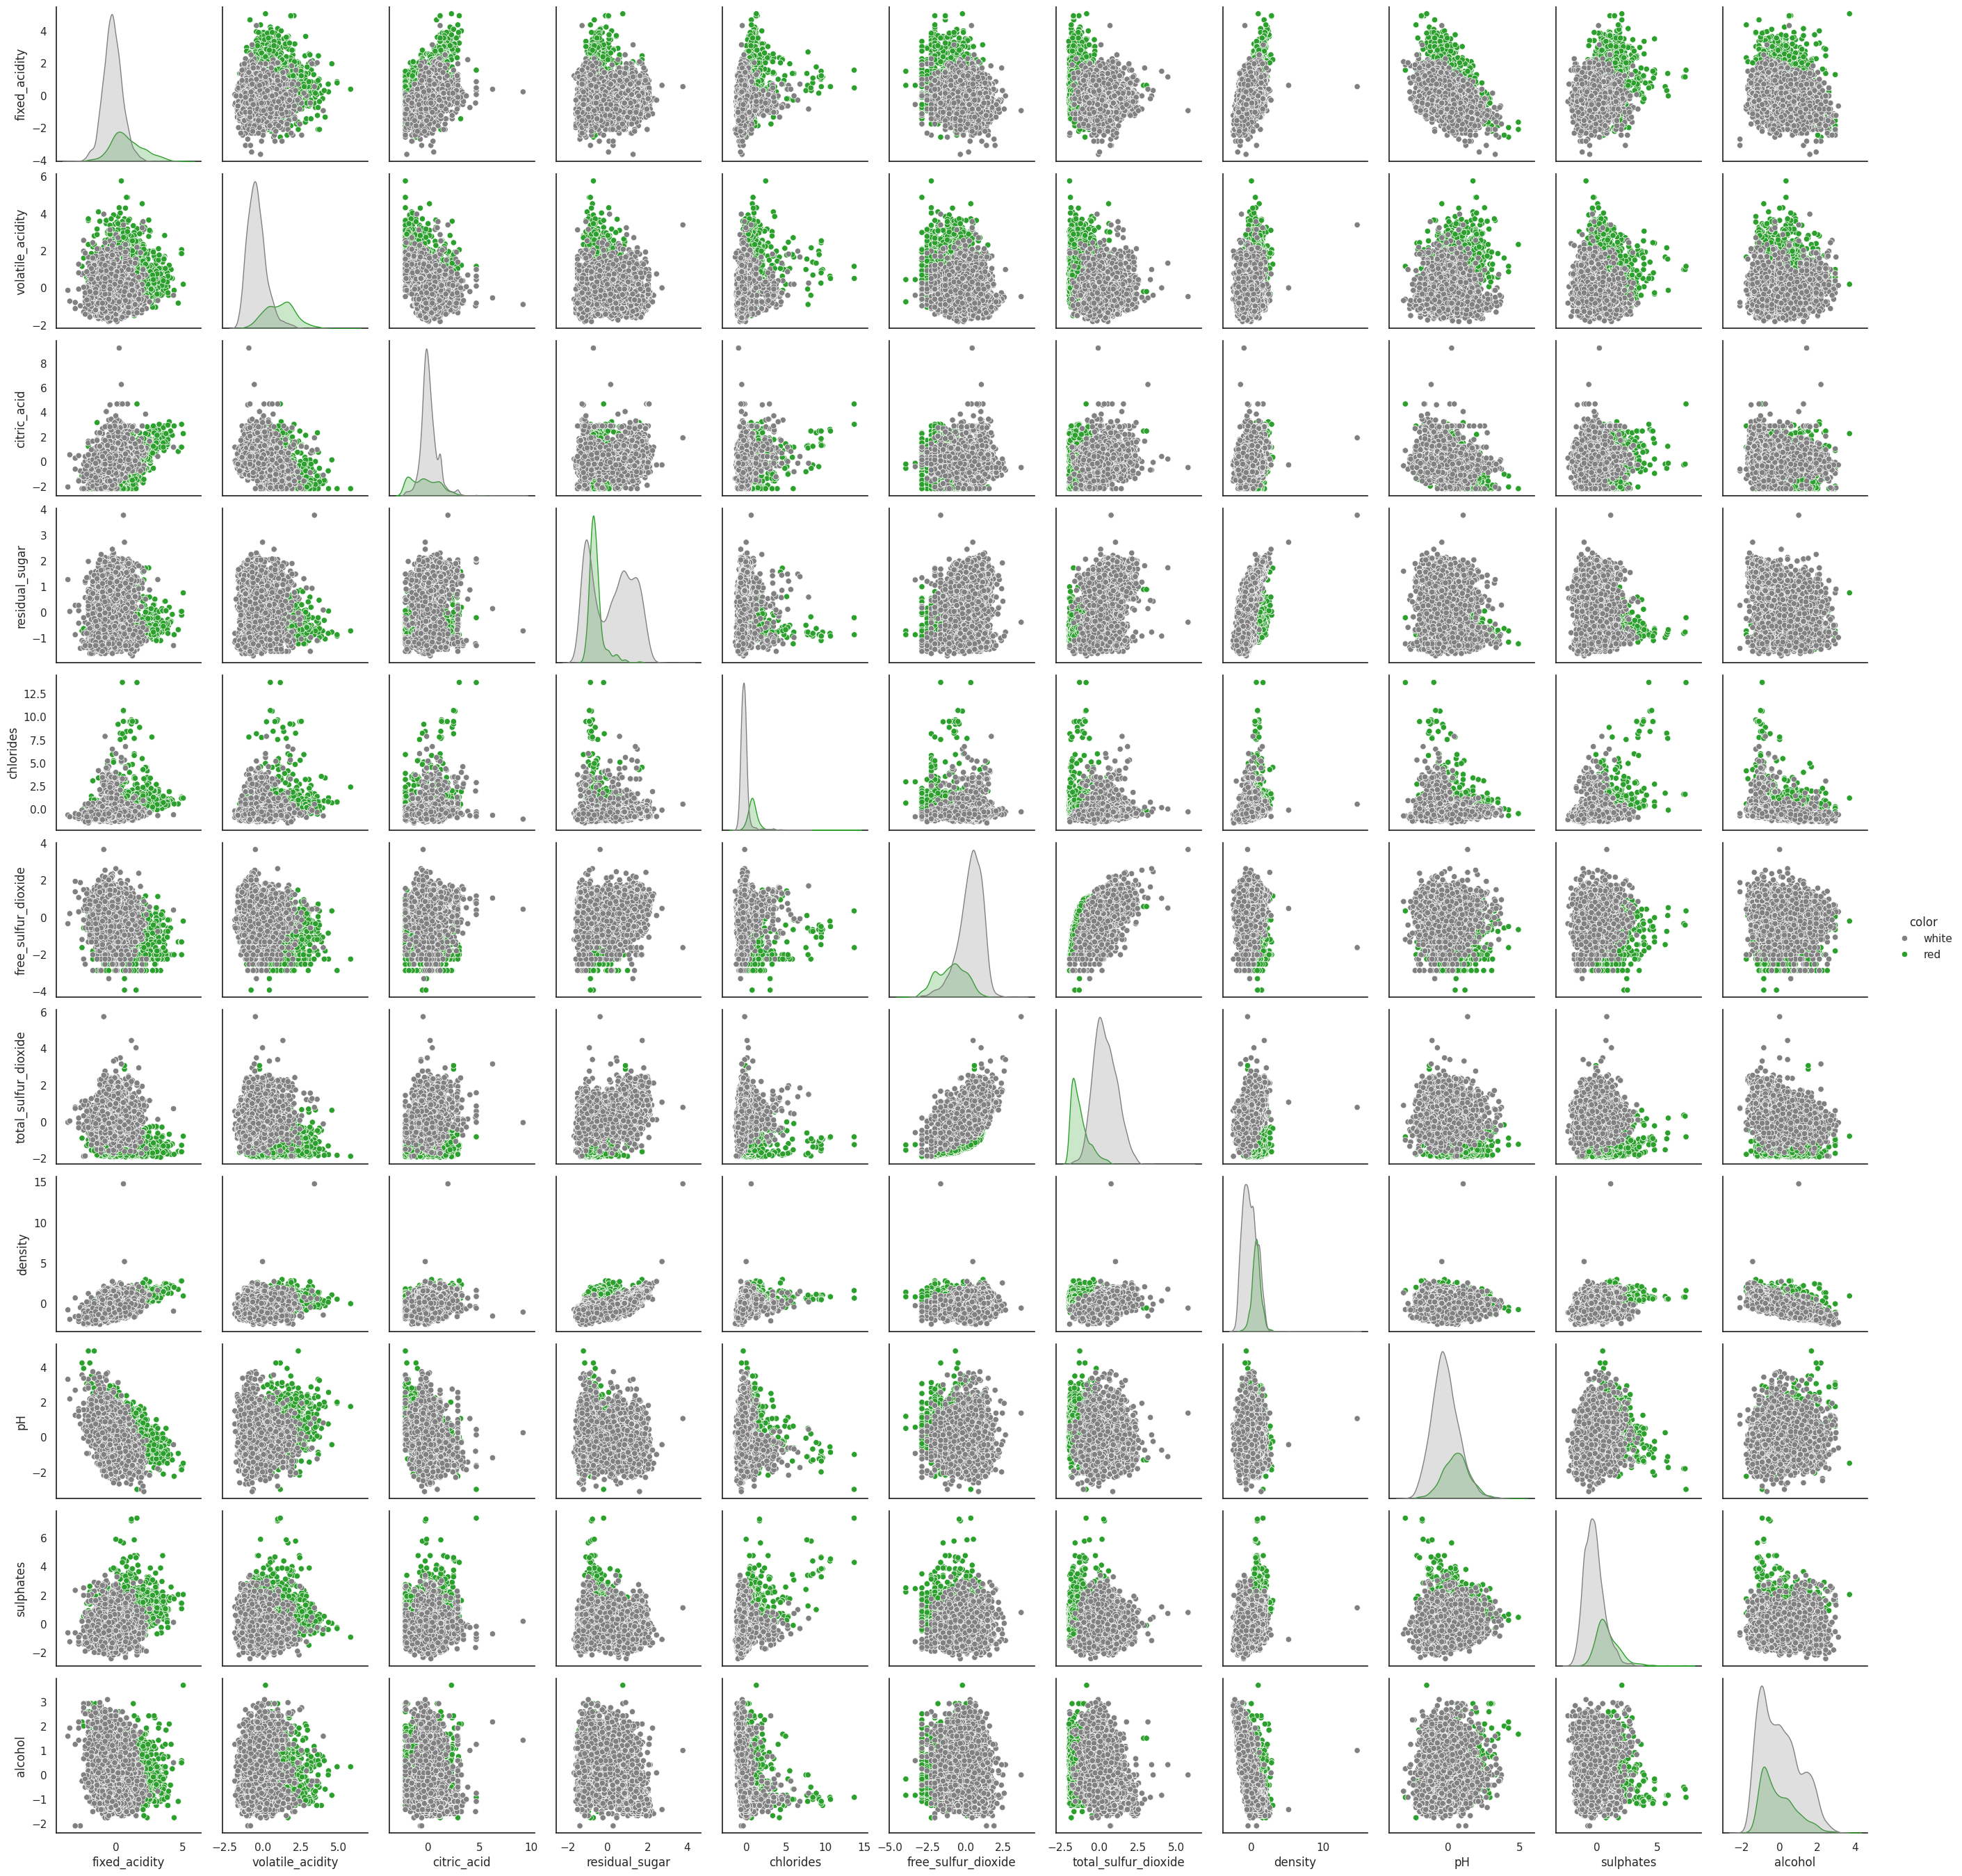

In [15]:
sns.set_context('notebook')
sns.pairplot(data[float_columns + ['color']], 
             hue='color', 
             hue_order=['white', 'red'],
             palette={'red':red, 'white':'gray'})

## Question 3

*   Fit a K-means clustering model with two clusters.
*   Examine the clusters by counting the number of red and white wines in each cluster.


In [16]:
km = KMeans(
    n_clusters=2,
    random_state=42
)
km.fit(data[float_columns])

KMeans(n_clusters=2, random_state=42)

In [17]:
data['kmeans'] = km.predict(data[float_columns])

In [18]:
(data[['color', 'kmeans']]
 .groupby(['kmeans', 'color'])
 .size()
 .to_frame()
 .rename(columns={0: 'number'}))

number
kmeans color        
0      red      1576
       white      87
1      red        23
       white    4811

## Question 4

*   Now fit K-Means models with cluster values ranging from 1 to 20.
*   For each model, store the number of clusters and the inertia value.
*   Plot cluster number vs inertia. Does there appear to be an ideal cluster number?


In [21]:
km_list = list()

for clust in range(1, 21):
    km = KMeans(
        n_clusters=clust,
        random_state=42
    )
    km.fit(data[float_columns])
    km_list.append(pd.Series({
        'clusters': clust,
        'inertia': km.inertia_,
        'model': km
    }))

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Inertia')]

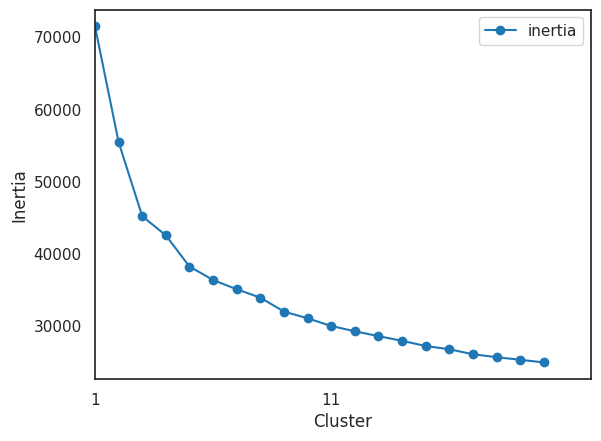

In [23]:
plot_data = (pd.concat(km_list, axis=1)
             .T[['clusters', 'inertia']]
             .set_index('clusters'))
ax = plot_data.plot(
    marker='o',
    ls='-'
)
ax.set_xticks(range(0, 21, 2))
ax.set_xlim(0, 21)
ax.set(xlabel='Cluster', ylabel='Inertia')

## Question 5

*   Fit an agglomerative clustering model with two clusters.
*   Compare the results to those obtained by K-means with regards to wine color by reporting the number of red and white observations in each cluster for both K-means and agglomerative clustering.
*   Visualize the dendrogram produced by agglomerative clustering. *Hint:* SciPy has a module called [`cluster.hierarchy`](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2022-01-01#module-scipy.cluster.hierarchy) that contains the `linkage` and `dendrogram` functions required to create the linkage map and plot the resulting dendrogram.


In [27]:
ag = AgglomerativeClustering(
    n_clusters=2,
    linkage='ward',
    compute_full_tree=True
)
ag.fit(data[float_columns])

AgglomerativeClustering(compute_full_tree=True)

In [28]:
data['agglom'] = ag.fit_predict(data[float_columns])

Note that cluster assignment is arbitrary, the respective primary cluster numbers for red and white may not be identical to the ones below and also may not be the same for both K-means and agglomerative clustering.


In [30]:
(data[['color', 'agglom', 'kmeans']]
 .groupby(['color', 'agglom'])
 .size()
 .to_frame()
 .rename(columns={0: 'number'}))

number
color agglom        
red   0           31
      1         1568
white 0         4755
      1          143

In [31]:
(data[['color','agglom','kmeans']]
 .groupby(['color','kmeans'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
color kmeans        
red   0         1576
      1           23
white 0           87
      1         4811

In [32]:
(data[['color','agglom','kmeans']]
 .groupby(['color','agglom','kmeans'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
color agglom kmeans        
red   0      0           13
             1           18
      1      0         1563
             1            5
white 0      0           38
             1         4717
      1      0           49
             1           94

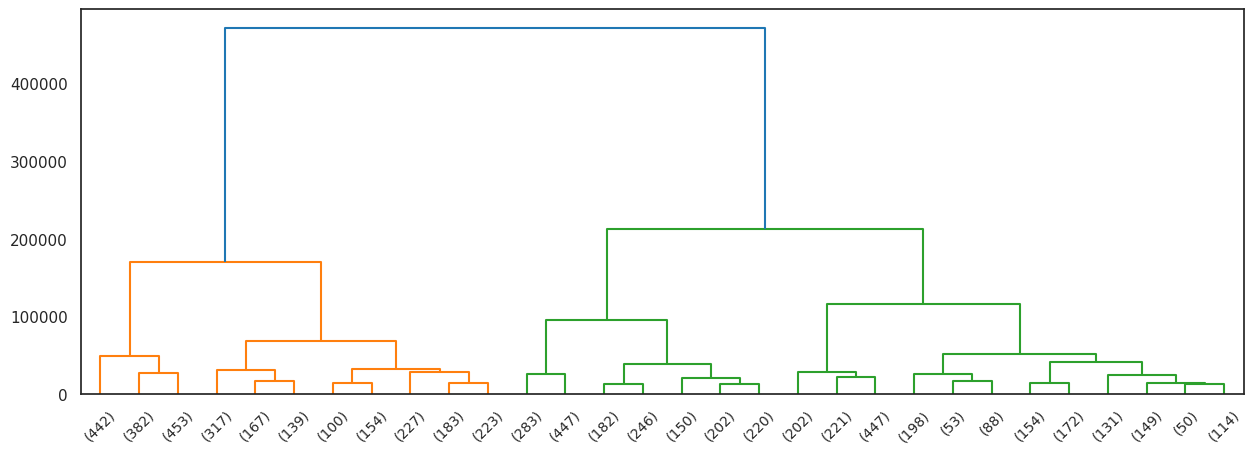

In [33]:
Z = hierarchy.linkage(ag.children_, method='ward')

fig, ax = plt.subplots(figsize=(15,5))


den = hierarchy.dendrogram(Z, orientation='top', 
                           p=30, truncate_mode='lastp',
                           show_leaf_counts=True, ax=ax)

## Question 6

In this question, we are going to explore clustering as a form of feature engineering.

*   Create a **binary** target variable `y`, denoting if the quality is greater than 7 or not.
*   Create a variable called `X_with_kmeans` from `data`, by dropping the columns "quality", "color" and "agglom" from the dataset. Create `X_without_kmeans` from that by dropping "kmeans".
*   For both datasets, using **[StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2022-01-01)** with 10 splits, fit 10 Random Forest Classifiers and find the mean of the ROC-AUC scores from these 10 classifiers.
*   Compare the average roc-auc scores for both models, the one using the KMeans cluster as a feature and the one that doesn't use it.


In [34]:
def get_avg_roc_10splits(estimator, X, y):
    roc_auc_list = []
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        estimator.fit(X_train, y_train)
        y_predicted = estimator.predict(X_test)
        y_scored = estimator.predict_proba(X_test)[:, 1]
        roc_auc_list.append(roc_auc_score(y_test, y_scored))
    return np.mean(roc_auc_list)

In [35]:
y = (data['quality'] > 7).astype(int)
X_with_kmeans = data.drop(['agglom', 'color', 'quality'], axis=1)
X_without_kmeans = X_with_kmeans.drop('kmeans', axis=1)
sss = StratifiedShuffleSplit(n_splits=10, random_state=6532)
# return classification_report(y_test, y_predicted)

In [36]:
estimator = RandomForestClassifier()
roc_with_kmeans = get_avg_roc_10splits(estimator, X_with_kmeans, y)
roc_without_kmeans = get_avg_roc_10splits(estimator, X_without_kmeans, y)
print("Without kmeans cluster as input to Random Forest, roc-auc is \"{0}\"".format(roc_without_kmeans))
print("Using kmeans cluster as input to Random Forest, roc-auc is \"{0}\"".format(roc_with_kmeans))

Without kmeans cluster as input to Random Forest, roc-auc is "0.9114087301587303"
Using kmeans cluster as input to Random Forest, roc-auc is "0.9030833333333333"


Let's now explore if the number of clusters have an effect in this improvement.

*   Create the basis training set from `data` by restricting to float_columns.
*   For $n = 1, \ldots, 20$, fit a KMeans algorithim with $n$ clusters. **[One-hot encode]()** it and add it to the **basis** training set. Don't add it to the previous iteration.
*   Fit 10 **Logistic Regression** models and compute the average roc-auc-score.
*   Plot the average roc-auc scores.


In [37]:
X_basis = data[float_columns]
sss = StratifiedShuffleSplit(n_splits=10, random_state=6532)

def create_kmeans_columns(n):
    km = KMeans(n_clusters=n)
    km.fit(X_basis)
    km_col = pd.Series(km.predict(X_basis))
    km_cols = pd.get_dummies(km_col, prefix='kmeans_cluster')
    return pd.concat([X_basis, km_cols], axis=1)

estimator = LogisticRegression()
ns = range(1, 21)
roc_auc_list = [get_avg_roc_10splits(estimator, create_kmeans_columns(n), y)
                for n in ns]

ax = plt.axes()
ax.plot(ns, roc_auc_list)
ax.set(
    xticklabels= ns,
    xlabel='Number of clusters as features',
    ylabel='Average ROC-AUC over 10 iterations',
    title='KMeans + LogisticRegression'
)
ax.grid(True)

NameError: name 'LogisticRegression' is not defined

***

### Machine Learning Foundation (C) 2020 IBM Corporation
